In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, roc_auc_score
)

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print('XGBoost not available. Will use Random Forest only.')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data and Train Model

Load features and train a model (we'll use Random Forest or XGBoost).

In [2]:
# Load features
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully
Dataset shape: (58817, 84)


In [3]:
# Identify target column
target_col = "Is_laundering"

if target_col in df.columns:
    print(f'Target column found: {target_col}')
    print(f'\nClass distribution:')
    print(df[target_col].value_counts())
else:
    print(f'ERROR: Target column "{target_col}" not found in dataset')
    print(f'Available columns: {df.columns.tolist()}')

Target column found: Is_laundering

Class distribution:
Is_laundering
0    49219
1     9598
Name: count, dtype: int64


In [4]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type', 'timestamp']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nFeature columns ({len(feature_cols)}): {feature_cols[:10]}...')

Features shape: (58817, 82)
Target shape: (58817,)

Feature columns (82): ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency_Albanian lek', 'Payment_currency_Dirham', 'Payment_currency_Euro', 'Payment_currency_Indian rupee', 'Payment_currency_Mexican Peso']...


In [5]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 47053 samples
Test set: 11764 samples


In [6]:
# Train model (prefer XGBoost if available, otherwise Random Forest)
if XGBOOST_AVAILABLE:
    print('Training XGBoost model...')
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )
    model_name = 'XGBoost'
else:
    print('Training Random Forest model...')
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    model_name = 'Random Forest'

model.fit(X_train, y_train)
print(f'{model_name} training complete.')

Training XGBoost model...
XGBoost training complete.


## 2. Get Prediction Probabilities

Get probability scores instead of hard predictions to enable threshold tuning.

In [7]:
# Get prediction probabilities for positive class (fraud/laundering)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Default predictions using 0.5 threshold
y_pred_default = (y_pred_proba >= 0.5).astype(int)

print(f'Probability scores (first 10): {y_pred_proba[:10]}')
print(f'\nProbability statistics:')
print(f'Min:  {y_pred_proba.min():.4f}')
print(f'Max:  {y_pred_proba.max():.4f}')
print(f'Mean: {y_pred_proba.mean():.4f}')
print(f'Median: {np.median(y_pred_proba):.4f}')

Probability scores (first 10): [0.10122093 0.33106866 0.08770426 0.09570935 0.01757226 0.1902227
 0.89430845 0.19625555 0.12149188 0.9991565 ]

Probability statistics:
Min:  0.0005
Max:  0.9998
Mean: 0.2504
Median: 0.0942


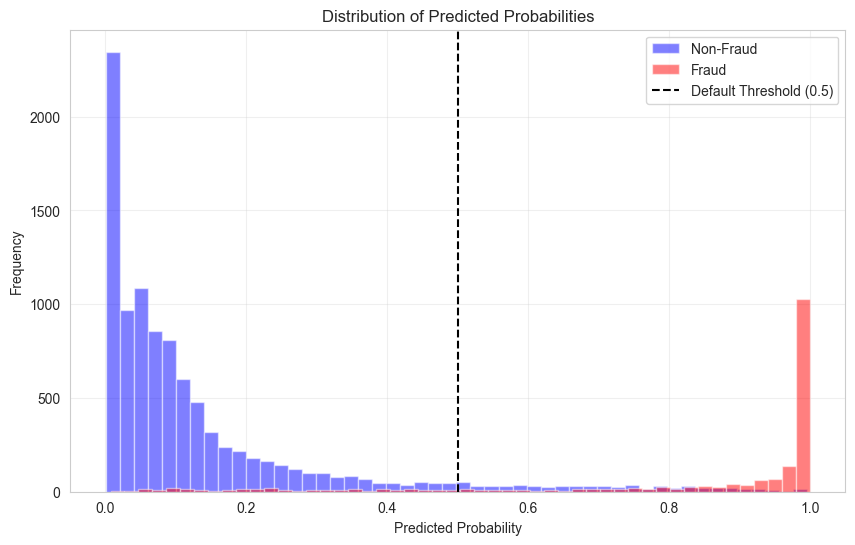

In [8]:
# Distribution of prediction probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Non-Fraud', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Fraud', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Baseline Performance (Default Threshold = 0.5)

First, evaluate performance using the default 0.5 threshold.

In [9]:
# Metrics with default threshold
default_accuracy = accuracy_score(y_test, y_pred_default)
default_precision = precision_score(y_test, y_pred_default)
default_recall = recall_score(y_test, y_pred_default)
default_f1 = f1_score(y_test, y_pred_default)

print('=' * 60)
print(f'{model_name} - DEFAULT THRESHOLD (0.5)')
print('=' * 60)
print(f'Accuracy:  {default_accuracy:.4f}')
print(f'Precision: {default_precision:.4f}')
print(f'Recall:    {default_recall:.4f}')
print(f'F1 Score:  {default_f1:.4f}')
print('=' * 60)

XGBoost - DEFAULT THRESHOLD (0.5)
Accuracy:  0.9265
Precision: 0.7325
Recall:    0.8656
F1 Score:  0.7935


## 4. Precision-Recall Curve

Plot the trade-off between precision and recall at different thresholds.

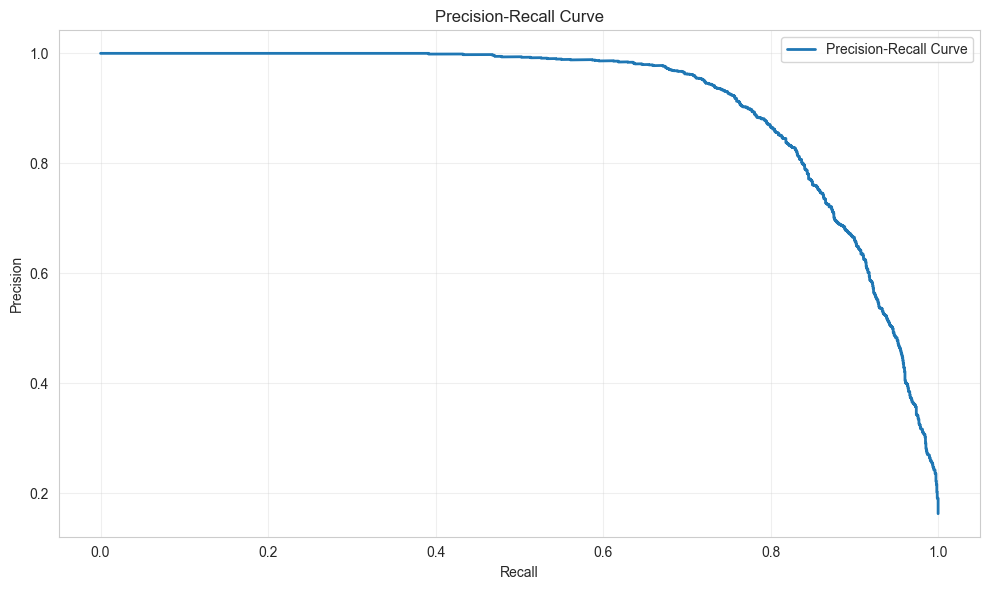

Number of thresholds evaluated: 11674


In [10]:
# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f'Number of thresholds evaluated: {len(pr_thresholds)}')

## 5. ROC Curve

Plot the Receiver Operating Characteristic curve.

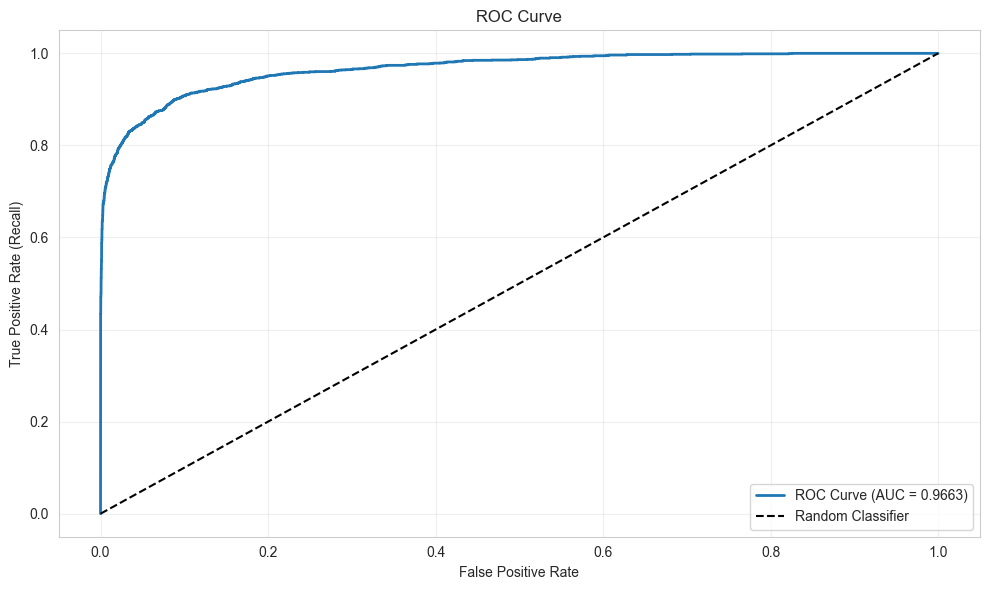

ROC-AUC Score: 0.9663


In [11]:
# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f'ROC-AUC Score: {roc_auc:.4f}')

## 6. Find Optimal Threshold Based on F1 Score

Test multiple thresholds and find the one that maximizes F1 score.

In [12]:
# Test thresholds from 0.1 to 0.9
thresholds_to_test = np.arange(0.1, 0.91, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

results_df = pd.DataFrame(results)
print('\nMetrics at Different Thresholds:')
print(results_df.to_string(index=False))


Metrics at Different Thresholds:
 Threshold  Accuracy  Precision   Recall  F1 Score
      0.10  0.675111   0.331800 0.977083  0.495379
      0.15  0.779072   0.422222 0.959896  0.586476
      0.20  0.828885   0.487550 0.948438  0.644032
      0.25  0.860592   0.542579 0.929167  0.685100
      0.30  0.884308   0.594203 0.918229  0.721506
      0.35  0.901309   0.639164 0.907813  0.750161
      0.40  0.911765   0.672941 0.893750  0.767785
      0.45  0.917630   0.696731 0.877083  0.776574
      0.50  0.926471   0.732481 0.865625  0.793507
      0.55  0.932081   0.761305 0.850521  0.803444
      0.60  0.937606   0.790117 0.841146  0.814834
      0.65  0.942112   0.816880 0.831771  0.824258
      0.70  0.945767   0.845366 0.817187  0.831038
      0.75  0.947722   0.873070 0.795312  0.832379
      0.80  0.948742   0.902752 0.768750  0.830380
      0.85  0.948912   0.936466 0.736979  0.824832
      0.90  0.946362   0.966691 0.695312  0.808846


In [13]:
# Find best threshold based on F1 score
best_f1_idx = results_df['F1 Score'].idxmax()
best_threshold = results_df.loc[best_f1_idx, 'Threshold']
best_f1 = results_df.loc[best_f1_idx, 'F1 Score']

print(f'\n' + '=' * 60)
print(f'BEST THRESHOLD FOR F1 SCORE: {best_threshold:.2f}')
print('=' * 60)
print(f'Best F1 Score: {best_f1:.4f}')
print('\nMetrics at best threshold:')
print(results_df.loc[best_f1_idx].to_string())
print('=' * 60)


BEST THRESHOLD FOR F1 SCORE: 0.75
Best F1 Score: 0.8324

Metrics at best threshold:
Threshold    0.750000
Accuracy     0.947722
Precision    0.873070
Recall       0.795312
F1 Score     0.832379


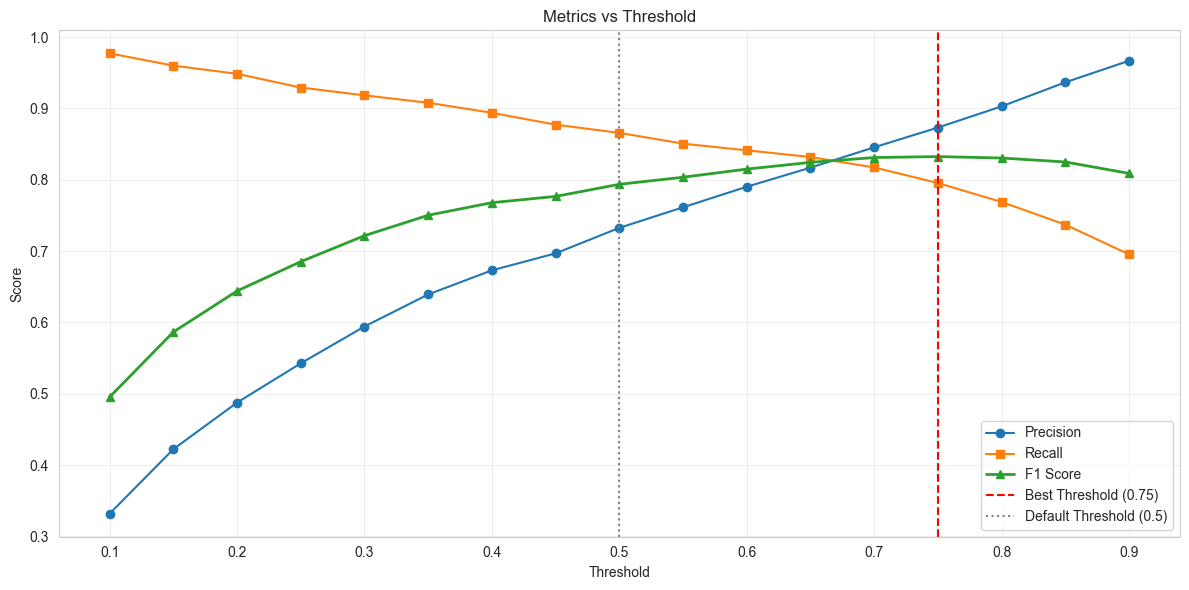

In [14]:
# Visualize metrics across thresholds
plt.figure(figsize=(12, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], marker='s', label='Recall')
plt.plot(results_df['Threshold'], results_df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.axvline(x=0.5, color='gray', linestyle=':', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Alternative: Find Threshold for Maximum Recall

For AML detection, we might prioritize recall over F1. Find threshold that maximizes recall while maintaining reasonable precision.

In [15]:
# Find threshold that gives recall >= 0.9 with highest F1
high_recall_df = results_df[results_df['Recall'] >= 0.85]

if len(high_recall_df) > 0:
    best_recall_idx = high_recall_df['F1 Score'].idxmax()
    recall_threshold = high_recall_df.loc[best_recall_idx, 'Threshold']
    
    print('=' * 60)
    print(f'THRESHOLD FOR HIGH RECALL (≥85%): {recall_threshold:.2f}')
    print('=' * 60)
    print(high_recall_df.loc[best_recall_idx].to_string())
    print('=' * 60)
else:
    # If no threshold gives recall >= 0.85, find one with highest recall
    best_recall_idx = results_df['Recall'].idxmax()
    recall_threshold = results_df.loc[best_recall_idx, 'Threshold']
    
    print('=' * 60)
    print(f'THRESHOLD FOR MAXIMUM RECALL: {recall_threshold:.2f}')
    print('=' * 60)
    print(results_df.loc[best_recall_idx].to_string())
    print('=' * 60)

THRESHOLD FOR HIGH RECALL (≥85%): 0.55
Threshold    0.550000
Accuracy     0.932081
Precision    0.761305
Recall       0.850521
F1 Score     0.803444


## 8. Confusion Matrix with Optimized Threshold

Compare confusion matrices using default threshold (0.5) vs optimized threshold.

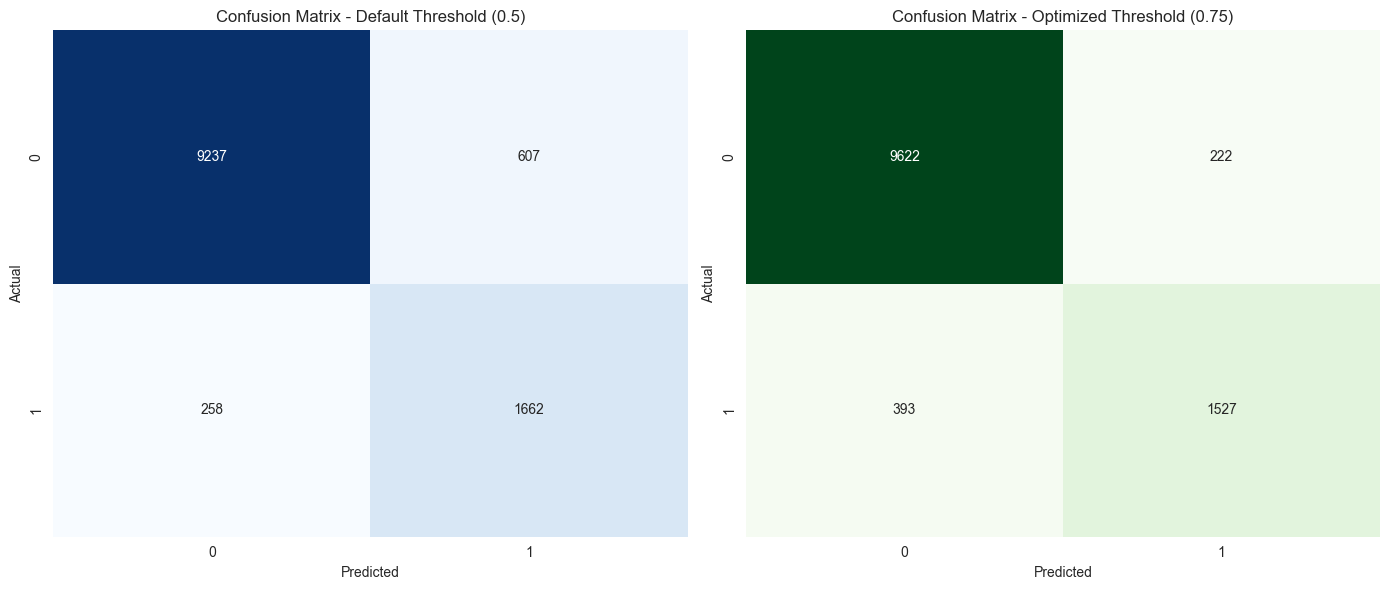

In [16]:
# Predictions with optimized threshold
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

# Confusion matrices
cm_default = confusion_matrix(y_test, y_pred_default)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Default threshold
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix - Default Threshold (0.5)')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Optimized threshold
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title(f'Confusion Matrix - Optimized Threshold ({best_threshold:.2f})')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [17]:
# Detailed comparison
print('\n' + '=' * 80)
print('CONFUSION MATRIX COMPARISON')
print('=' * 80)
print(f'\nDefault Threshold (0.5):')
print(f'  True Negatives:  {cm_default[0, 0]:,}')
print(f'  False Positives: {cm_default[0, 1]:,}')
print(f'  False Negatives: {cm_default[1, 0]:,}')
print(f'  True Positives:  {cm_default[1, 1]:,}')

print(f'\nOptimized Threshold ({best_threshold:.2f}):')
print(f'  True Negatives:  {cm_optimized[0, 0]:,}')
print(f'  False Positives: {cm_optimized[0, 1]:,}')
print(f'  False Negatives: {cm_optimized[1, 0]:,}')
print(f'  True Positives:  {cm_optimized[1, 1]:,}')

print(f'\nChanges:')
print(f'  False Negatives: {cm_default[1, 0]:,} → {cm_optimized[1, 0]:,} (Change: {cm_optimized[1, 0] - cm_default[1, 0]:+,})')
print(f'  True Positives:  {cm_default[1, 1]:,} → {cm_optimized[1, 1]:,} (Change: {cm_optimized[1, 1] - cm_default[1, 1]:+,})')
print('=' * 80)


CONFUSION MATRIX COMPARISON

Default Threshold (0.5):
  True Negatives:  9,237
  False Positives: 607
  False Negatives: 258
  True Positives:  1,662

Optimized Threshold (0.75):
  True Negatives:  9,622
  False Positives: 222
  False Negatives: 393
  True Positives:  1,527

Changes:
  False Negatives: 258 → 393 (Change: +135)
  True Positives:  1,662 → 1,527 (Change: -135)


## 9. Final Performance with Optimized Threshold

In [18]:
# Calculate metrics with optimized threshold
opt_accuracy = accuracy_score(y_test, y_pred_optimized)
opt_precision = precision_score(y_test, y_pred_optimized)
opt_recall = recall_score(y_test, y_pred_optimized)
opt_f1 = f1_score(y_test, y_pred_optimized)

# Create comparison
comparison = pd.DataFrame({
    'Threshold': ['Default (0.5)', f'Optimized ({best_threshold:.2f})'],
    'Accuracy': [default_accuracy, opt_accuracy],
    'Precision': [default_precision, opt_precision],
    'Recall': [default_recall, opt_recall],
    'F1 Score': [default_f1, opt_f1]
})

print('\n' + '=' * 90)
print('PERFORMANCE COMPARISON: DEFAULT vs OPTIMIZED THRESHOLD')
print('=' * 90)
print(comparison.to_string(index=False))
print('=' * 90)


PERFORMANCE COMPARISON: DEFAULT vs OPTIMIZED THRESHOLD
       Threshold  Accuracy  Precision   Recall  F1 Score
   Default (0.5)  0.926471   0.732481 0.865625  0.793507
Optimized (0.75)  0.947722   0.873070 0.795312  0.832379


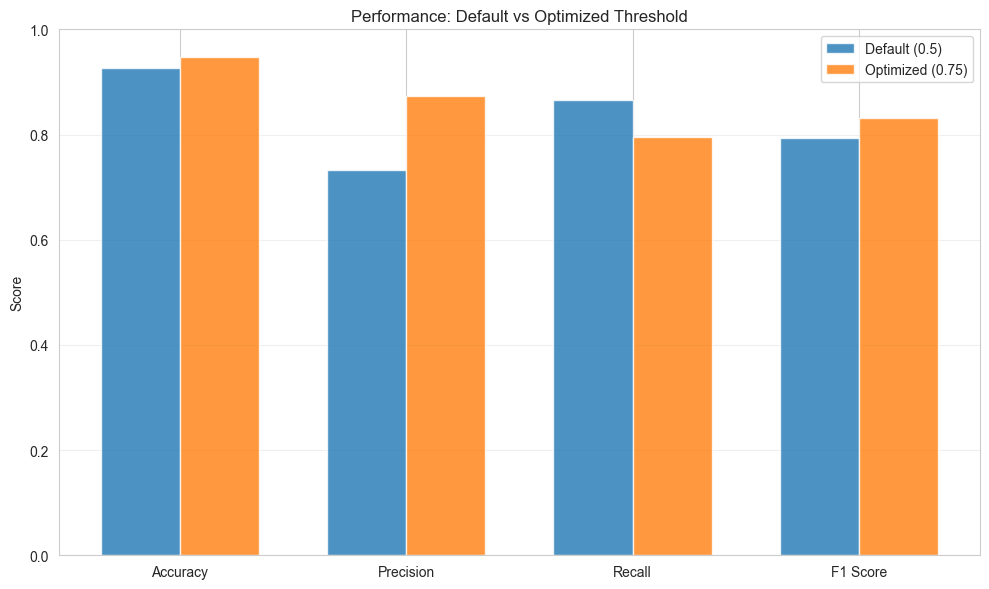

In [19]:
# Visualize improvement
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
default_scores = [default_accuracy, default_precision, default_recall, default_f1]
optimized_scores = [opt_accuracy, opt_precision, opt_recall, opt_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, default_scores, width, label='Default (0.5)', alpha=0.8)
ax.bar(x + width/2, optimized_scores, width, label=f'Optimized ({best_threshold:.2f})', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Performance: Default vs Optimized Threshold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### Key Findings:

**Default Threshold (0.5):**
- Standard approach used by most classifiers
- May not be optimal for imbalanced problems
- Balances precision and recall equally

**Threshold Optimization:**
- By adjusting the decision threshold, we can control the precision-recall trade-off
- Lower threshold → Higher recall (catch more fraud) but lower precision (more false alarms)
- Higher threshold → Higher precision (fewer false alarms) but lower recall (miss more fraud)

**For AML Detection:**
- **Recall is critical** - missing fraud cases is expensive
- A lower threshold is often preferred to maximize fraud detection
- False positives (flagging legitimate transactions) can be reviewed manually

**Best Threshold Selection:**
- **F1-optimal threshold**: Balances precision and recall
- **Recall-focused threshold**: Prioritizes catching fraud cases
- Business requirements should guide the final choice

### Recommendation:

Use the optimized threshold identified in this notebook for the final model. The threshold can be adjusted based on:
- Cost of false negatives (missed fraud)
- Cost of false positives (manual review burden)
- Available resources for investigation